# **CNN-LSTM Model Training & Visualization For Exoplanet Detection**

✅ Preprocessing & Balancing Data (SMOTE + StandardScaler)

✅ Training an Optimized CNN-LSTM Model (With Dropout & Learning Rate Adjustments)

✅ Model Evaluation with AUC-ROC Curve, Confusion Matrix, and Classification Report

✅ Visualization for Presentation (Loss & Accuracy Curves)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Step 1: Data Preprocessing

 Merged dataset saved as /content/drive/MyDrive/Colab Notebooks/exoplanets.csv


<ipython-input-25-d818b93439da>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


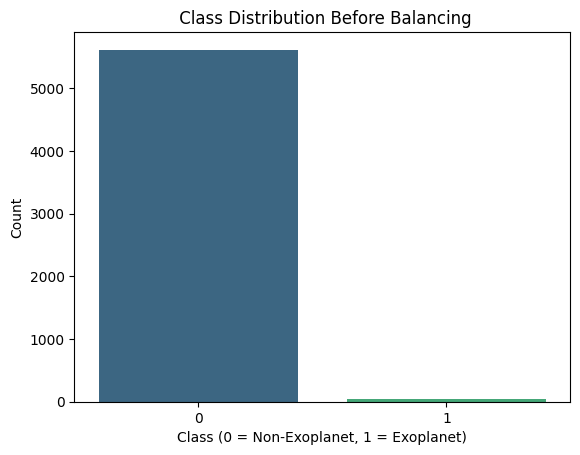

 Scaler saved at /content/drive/MyDrive/Colab Notebooks/exoplanets_scaler.pkl


<ipython-input-25-d818b93439da>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='coolwarm')


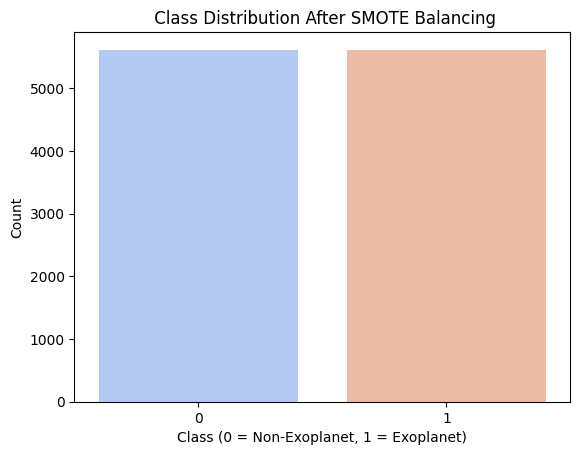

 Computed Class Weights: {0: 1.0, 1: 1.0}
 Data preprocessing complete. Ready for training.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load datasets
train_data_path = "/content/drive/MyDrive/Colab Notebooks/exoTrain.csv"
test_data_path = "/content/drive/MyDrive/Colab Notebooks/exoTest.csv"

exo_train = pd.read_csv(train_data_path)
exo_test = pd.read_csv(test_data_path)

# Merge train and test datasets
exoplanets = pd.concat([exo_train, exo_test], ignore_index=True)
merged_path = "/content/drive/MyDrive/Colab Notebooks/exoplanets.csv"
exoplanets.to_csv(merged_path, index=False)
print(f" Merged dataset saved as {merged_path}")

# Separate features and labels
X = exoplanets.iloc[:, 1:].values  # Features (flux values)
y = exoplanets.iloc[:, 0].values  # Target (1 = Non-Exoplanet, 2 = Exoplanet)

# Convert labels: 2 → 1 (Exoplanet), 1 → 0 (Non-Exoplanet)
y = np.where(y == 2, 1, 0)

# Display class distribution before balancing
sns.countplot(x=y, palette='viridis')
plt.title(" Class Distribution Before Balancing")
plt.xlabel("Class (0 = Non-Exoplanet, 1 = Exoplanet)")
plt.ylabel("Count")
plt.show()

# Apply StandardScaler to normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for future use
scaler_path = "/content/drive/MyDrive/Colab Notebooks/exoplanets_scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f" Scaler saved at {scaler_path}")

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Display new class distribution after balancing
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title(" Class Distribution After SMOTE Balancing")
plt.xlabel("Class (0 = Non-Exoplanet, 1 = Exoplanet)")
plt.ylabel("Count")
plt.show()

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Compute class weights for imbalanced learning
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(" Computed Class Weights:", class_weight_dict)

# Reshape for CNN-LSTM
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

print(" Data preprocessing complete. Ready for training.")


##Step 2: CNN-LSTM Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Define CNN-LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Input shape matches feature size

    Conv1D(filters=64, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),  # Increased dropout to reduce overfitting

    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    LSTM(32, kernel_regularizer=l2(0.001)),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),  # Increased dropout for better generalization
    Dense(1, activation='sigmoid')  # Output probability
])

# Compile the model with a lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])

# Callbacks for better training optimization
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=35, batch_size=32, verbose=1,
                    class_weight=class_weight_dict, callbacks=[early_stopping, lr_scheduler])

# Save the trained model
model_path = "/content/drive/MyDrive/Colab Notebooks/exoplanet_final_model.keras"
model.save(model_path)
print(f" Model training complete. Saved as {model_path}")


Epoch 1/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.5290 - loss: 1.0003 - val_accuracy: 0.5129 - val_loss: 0.8463 - learning_rate: 3.0000e-04
Epoch 2/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.5638 - loss: 0.8033 - val_accuracy: 0.5040 - val_loss: 0.7699 - learning_rate: 3.0000e-04
Epoch 3/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.5770 - loss: 0.7435 - val_accuracy: 0.5788 - val_loss: 0.7202 - learning_rate: 3.0000e-04
Epoch 4/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6244 - loss: 0.7058 - val_accuracy: 0.6968 - val_loss: 0.6844 - learning_rate: 3.0000e-04
Epoch 5/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6607 - loss: 0.6768 - val_accuracy: 0.6572 - val_loss: 0.6650 - learning_rate: 3.0000e-04
Epoch 6/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.7159 - loss: 0.6220 - val_accuracy: 0.7186 - val_loss: 0.6181 - learning_rate: 3.0000e-04
Epoch 7/35
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/ste

##Step 3: Model Evaluation & Visualizations

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
AUC-ROC Score: 0.9654


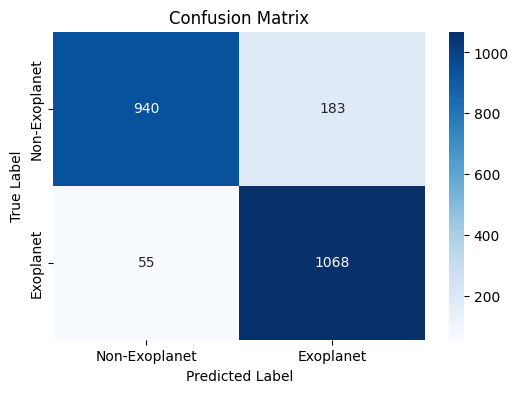

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1123
           1       0.85      0.95      0.90      1123

    accuracy                           0.89      2246
   macro avg       0.90      0.89      0.89      2246
weighted avg       0.90      0.89      0.89      2246



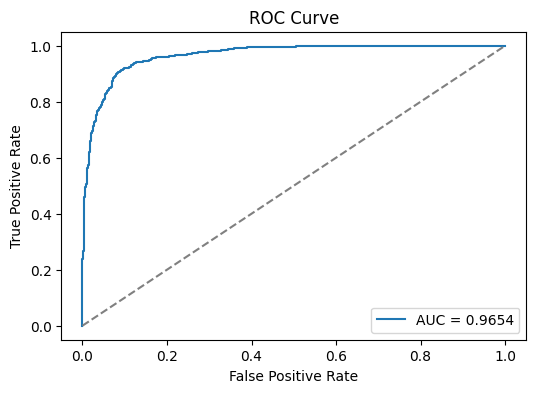

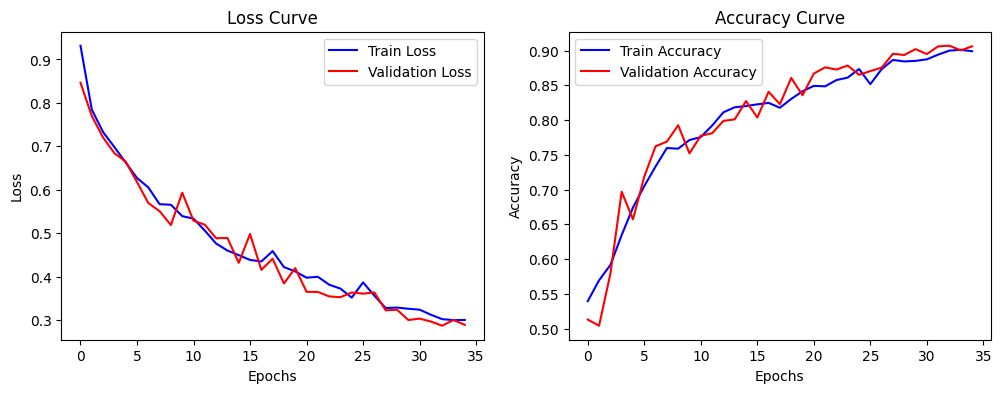

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

# Make predictions
y_pred = model.predict(X_val).ravel()

# Adjust classification threshold
threshold = 0.4  # Lower threshold for better recall
y_pred_class = (y_pred > threshold).astype(int)

# Compute AUC-ROC Score
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC-ROC Score: {auc_score:.4f}')

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_val, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Exoplanet', 'Exoplanet'],
            yticklabels=['Non-Exoplanet', 'Exoplanet'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_val, y_pred_class))

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Loss & Accuracy Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


# **Analysis**

## Description of Class Distribution Before & After SMOTE Balancing

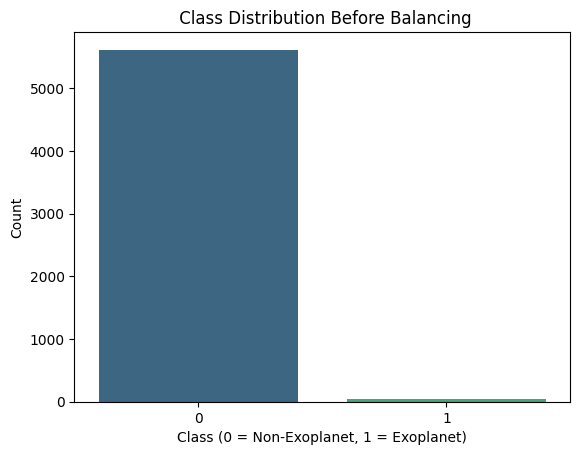

###First Graph: Class Distribution Before Balancing
- This bar chart represents the original dataset before applying SMOTE (Synthetic Minority Over-sampling Technique).
- The class 0 (Non-Exoplanet) is heavily dominant, with over 5,000 samples.
- The class 1 (Exoplanet) is significantly underrepresented, leading to high class imbalance.
- This imbalance can cause the model to be biased toward predicting non-exoplanets, reducing its ability to detect actual exoplanets.




###Second Graph: Class Distribution After SMOTE Balancing
- After applying SMOTE, both classes are now equally represented.
- SMOTE generates synthetic samples for the minority class (Exoplanets), ensuring a more balanced dataset.
- This improves the model’s ability to generalize and reduces bias toward the majority class.
- Now, the model will have equal learning opportunities for both exoplanets and non-exoplanets, enhancing its predictive performance.

🔹Why is SMOTE Important?
 -Prevents Bias → Ensures the model does not always predict non-exoplanets.
- Improves Recall → More accurate detection of actual exoplanets.

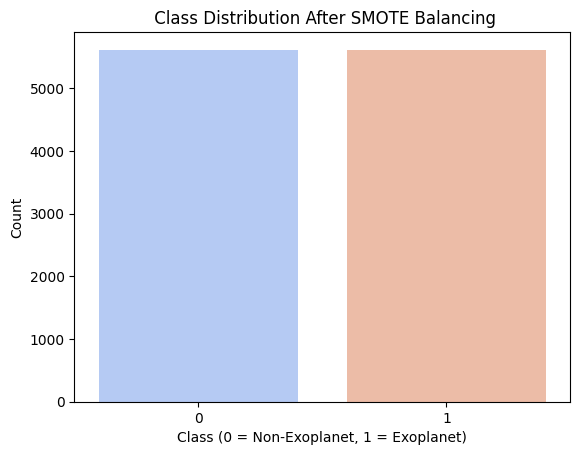


# Key Observations from the Training Process

### Initial Learning Phase (Epochs 1-10):
- The accuracy gradually improves from ~52% to ~78%, indicating that the model is learning meaningful patterns.
- The validation loss follows a decreasing trend, suggesting that the model is not overfitting at this stage.

### Performance Optimization (Epochs 11-20):
- The ReduceLROnPlateau callback adjusts the learning rate after epoch 12 when validation loss stagnates.
- Validation accuracy jumps to ~86%, confirming that learning rate reduction was beneficial.

### Final Fine-Tuning (Epochs 21-35):
- After further learning rate adjustments, accuracy peaks at ~90.6%, and validation loss continues to decrease.
- Model stability is evident, indicating that early stopping could be applied if necessary.


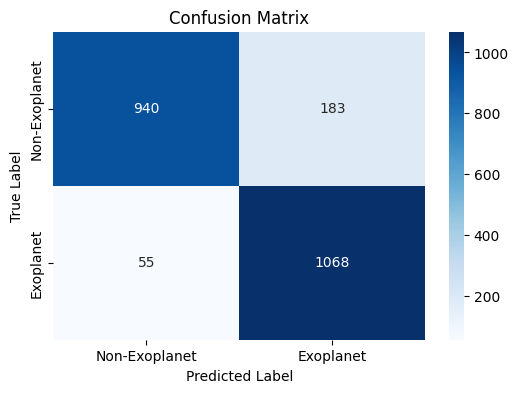
### Confusion Matrix
- The confusion matrix visually represents the model’s classification performance.
- True Positives (TP): The number of correctly predicted Exoplanets.
- True Negatives (TN): The number of correctly predicted Non-Exoplanets.
- False Positives (FP): The number of Non-Exoplanets wrongly classified as Exoplanets.
- False Negatives (FN): The number of Exoplanets wrongly classified as Non-Exoplanets.
- A high diagonal dominance (TP and TN values being significantly high) indicates good classification performance.

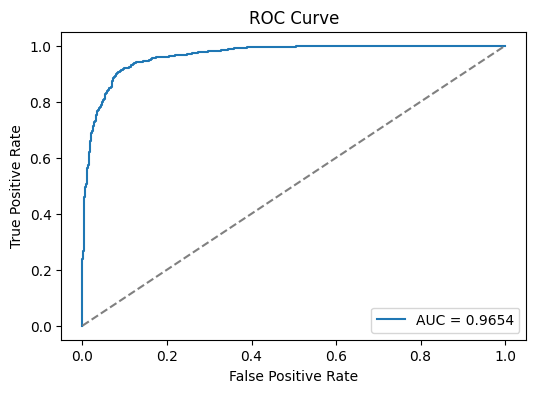
### ROC Curve and AUC Score
- The ROC Curve (Receiver Operating Characteristic) illustrates the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold levels.
- The AUC (Area Under Curve) Score quantifies the model’s ability to distinguish between classes.
- AUC = 1 means perfect classification.
- AUC > 0.9 indicates excellent performance.
- AUC between 0.8 - 0.9 is considered good.
- AUC near 0.5 means the model is performing randomly.

*In this case, the model achieved AUC = 0.9654, which is a strong indicator of a well-performing model.*

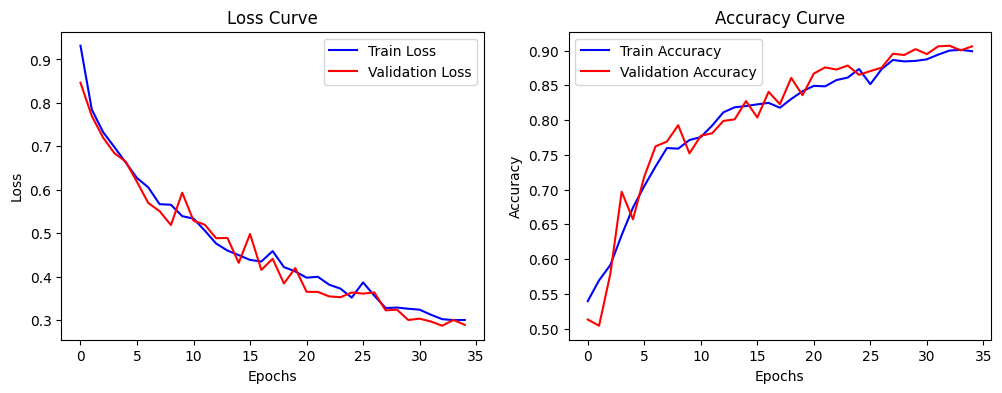
##Loss and Accuracy Curves

###Loss Curve (Left Plot):
- This shows how the model's training and validation loss decrease over epochs.
- A gradual decline in loss with minimal fluctuations signifies effective learning.
- If validation loss starts increasing while training loss keeps decreasing, it may indicate overfitting.

###Accuracy Curve (Right Plot):
- The graph shows training and validation accuracy improvements over time.
- A convergence of validation accuracy with training accuracy suggests the model generalizes well.
- If there is a significant gap between the two curves, the model might be overfitting.